In [10]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import time 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support 
%matplotlib inline
from IPython.display import display
from six import StringIO
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

from scipy.stats import pearsonr
from sklearn.utils import resample

from sklearn.cluster import KMeans 
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import davies_bouldin_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering


In [11]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder

DIAMETER_METHODS = ['mean_cluster', 'farthest']
CLUSTER_DISTANCE_METHODS = ['nearest', 'farthest']


def inter_cluster_distances(labels, distances, method='nearest'):
  
    if method not in CLUSTER_DISTANCE_METHODS:
        raise ValueError(
            'method must be one of {}'.format(CLUSTER_DISTANCE_METHODS))

    if method == 'nearest':
        return __cluster_distances_by_points(labels, distances)
    elif method == 'farthest':
        return __cluster_distances_by_points(labels, distances, farthest=True)


def __cluster_distances_by_points(labels, distances, farthest=False):
    n_unique_labels = len(np.unique(labels))
    cluster_distances = np.full((n_unique_labels, n_unique_labels),
                                float('inf') if not farthest else 0)

    np.fill_diagonal(cluster_distances, 0)

    for i in np.arange(0, len(labels) - 1):
        for ii in np.arange(i, len(labels)):
            if labels[i] != labels[ii] and (
                (not farthest and
                 distances[i, ii] < cluster_distances[labels[i], labels[ii]])
                    or
                (farthest and
                 distances[i, ii] > cluster_distances[labels[i], labels[ii]])):
                cluster_distances[labels[i], labels[ii]] = cluster_distances[
                    labels[ii], labels[i]] = distances[i, ii]
    return cluster_distances


def diameter(labels, distances, method='farthest'):
   
    if method not in DIAMETER_METHODS:
        raise ValueError('method must be one of {}'.format(DIAMETER_METHODS))

    n_clusters = len(np.unique(labels))
    diameters = np.zeros(n_clusters)

    if method == 'mean_cluster':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii]:
                    diameters[labels[i]] += distances[i, ii]

        for i in range(len(diameters)):
            diameters[i] /= sum(labels == i)

    elif method == 'farthest':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii] and distances[i, ii] > diameters[
                        labels[i]]:
                    diameters[labels[i]] = distances[i, ii]
    return diameters


def dunn(labels, distances, diameter_method='farthest',
         cdist_method='nearest'):
    

    labels = LabelEncoder().fit(labels).transform(labels)

    ic_distances = inter_cluster_distances(labels, distances, cdist_method)
    min_distance = min(ic_distances[ic_distances.nonzero()])
    max_diameter = max(diameter(labels, distances, diameter_method))

    return min_distance / max_diameter


In [12]:
from IPython.display import display, HTML
from sklearn.tree import _tree, DecisionTreeClassifier
import pandas as pd

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
    inner_tree: _tree.Tree = tree.tree_
    classes = tree.classes_
    class_rules_dict = dict()
    
    
    def tree_dfs(node_id=0, current_rule=[]):
        split_feature = inner_tree.feature[node_id]
        if split_feature != _tree.TREE_UNDEFINED: # internal node
            name = feature_names[split_feature]
            threshold = inner_tree.threshold[node_id]
      # left child
            left_rule = current_rule + ["{} <= {}".format(name, threshold)]
            tree_dfs(inner_tree.children_left[node_id], left_rule)
      # right child
            right_rule = current_rule + ["{} > {}".format(name, threshold)]
            tree_dfs(inner_tree.children_right[node_id], right_rule)
        else: # leaf
            dist = inner_tree.value[node_id][0]
            dist = dist/dist.sum()
            max_idx = dist.argmax()
            if len(current_rule) == 0:
                rule_string = "ALL"
            else:
                rule_string = " and ".join(current_rule)
      # register new rule to dictionary
            selected_class = classes[max_idx]
            class_probability = dist[max_idx]
            class_rules = class_rules_dict.get(selected_class, [])
            class_rules.append((rule_string, class_probability))
            class_rules_dict[selected_class] = class_rules
    
    tree_dfs() # start from root, node_id = 0
    return class_rules_dict

def cluster_report(data: pd.DataFrame, clusters, min_samples_leaf=50, pruning_level=0.01):
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level)
    tree.fit(data, clusters)
    
    # Generate Report
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['class_name', 'instance_count']
    report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
    print(feature_names)
    pretty_print(report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']])

In [13]:
dataf=pd.read_csv('FULL DATA.csv')

dataf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   AGEGROUP     300 non-null    int64
 1   ageinmonths  300 non-null    int64
 2   PV           300 non-null    int64
 3   SR           300 non-null    int64
 4   GU           300 non-null    int64
 5   REFMNG       300 non-null    int64
 6   RELMNG       300 non-null    int64
 7   EL           300 non-null    int64
 8   TOTAL        300 non-null    int64
dtypes: int64(9)
memory usage: 21.2 KB


# Peason correlation

In [14]:
dataf.corr(method = 'pearson', min_periods = 1)

,AGEGROUP,ageinmonths,PV,SR,GU,REFMNG,RELMNG,EL,TOTAL
AGEGROUP,1.000000,0.989484,0.760785,0.744749,0.550699,0.791940,0.818825,0.815002,0.938661
ageinmonths,0.989484,1.000000,0.770036,0.753923,0.542752,0.799050,0.823412,0.809715,0.942078
PV,0.760785,0.770036,1.000000,0.647086,0.556428,0.647359,0.594285,0.668376,0.819717
SR,0.744749,0.753923,0.647086,1.000000,0.394013,0.619371,0.645616,0.650380,0.805296
GU,0.550699,0.542752,0.556428,0.394013,1.000000,0.356654,0.428535,0.538894,0.613950
REFMNG,0.791940,0.799050,0.647359,0.619371,0.356654,1.000000,0.693055,0.606768,0.812597
RELMNG,0.818825,0.823412,0.594285,0.645616,0.428535,0.693055,1.000000,0.680759,0.872470
EL,0.815002,0.809715,0.668376,0.650380,0.538894,0.606768,0.680759,1.000000,0.871268
TOTAL,0.938661,0.942078,0.819717,0.805296,0.613950,0.812597,0.872470,0.871268,1.000000


In [15]:

lc=list(dataf.columns)
lc2=lc.copy()
pcclist=[]

minscore=2
maxscore=0

for n1 in lc:
    #print('Correlation for '+n1)
    #print(lc.index(n1))
    lc2.remove(n1)
    for n2 in lc2:
        list1 = dataf[lc[lc.index(n1)]]
        list2 = dataf[lc2[lc2.index(n2)]]
        corr, _ = pearsonr(list1, list2)
        name2=str(n1 +' and '+n2)
        pccitem=[name2,corr]
        pcclist.append(pccitem)
        #print(name2)
        #print(n1 +' and '+ n2 + ' is : %.3f' % corr)
        #plt.scatter(dataf[lc[lc.index(n1)]], dataf[lc2[lc2.index(n2)]])
        if corr< minscore:
            minscore=corr
            minatr1=n1
            minatr2=n2
        if corr> maxscore:
            maxscore=corr
            maxatr1=n1
            maxatr2=n2

print(minatr1 +' and '+ minatr2 + ' is : %.3f' % minscore)
print(maxatr1 +' and '+ maxatr2 + ' is : %.3f' % maxscore)

GU and REFMNG is : 0.357
AGEGROUP and ageinmonths is : 0.989


In [16]:
pccdf = pd.DataFrame(pcclist, columns =['Attributes', 'Correlation'])

pccdf.sort_values(by='Correlation').head(10)


,Attributes,Correlation
26,GU and REFMNG,0.356654
21,SR and GU,0.394013
27,GU and RELMNG,0.428535
28,GU and EL,0.538894
10,ageinmonths and GU,0.542752
3,AGEGROUP and GU,0.550699
16,PV and GU,0.556428
18,PV and RELMNG,0.594285
31,REFMNG and EL,0.606768
29,GU and TOTAL,0.613950


In [17]:
print(dataf.var())

AGEGROUP          2.926421
ageinmonths     107.581839
PV               30.583099
SR               26.069967
GU               14.255017
REFMNG           35.382598
RELMNG          104.943266
EL               81.527313
TOTAL          1074.694437
dtype: float64


In [18]:
from sklearn.feature_selection import VarianceThreshold

vhold=VarianceThreshold(threshold=50)
vhold.fit(dataf)
vhold.get_support()

array([False,  True, False, False, False, False,  True,  True,  True])

# Drop features

In [19]:
df=dataf.drop(['AGEGROUP', 'ageinmonths','TOTAL','PV','SR'], axis = 1)
df.head()

,GU,REFMNG,RELMNG,EL
0,3,8,4,2
1,6,1,4,0
2,7,0,2,0
3,11,0,0,1
4,10,2,0,0


In [20]:
df.corr(method = 'pearson', min_periods = 1)

,GU,REFMNG,RELMNG,EL
GU,1.000000,0.356654,0.428535,0.538894
REFMNG,0.356654,1.000000,0.693055,0.606768
RELMNG,0.428535,0.693055,1.000000,0.680759
EL,0.538894,0.606768,0.680759,1.000000


In [21]:
a1=2
a2=3
xatt=df.iloc[:,lambda df: [a1,a2]]
print(xatt)

     RELMNG  EL
0         4   2
1         4   0
2         2   0
3         0   1
4         0   0
..      ...  ..
295      20  18
296      33  24
297      33  25
298      32  28
299      33  28

[300 rows x 2 columns]


# sampling

In [22]:
numk=4

561 0.43342145285498646
649 0.0844551219150681
649 0.8565809469345793


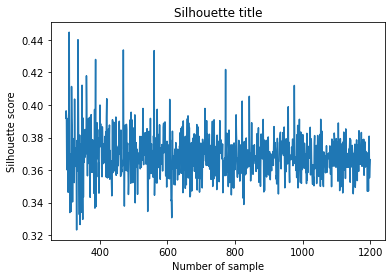

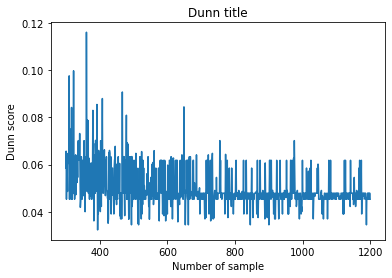

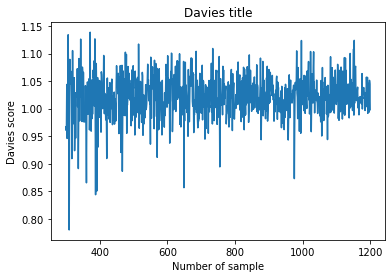

In [38]:


lendf= int(len(df))
doublelen=4*lendf

samsil=[]
samdun=[]
samdav=[]

maxsil=0
maxdun=0
mindav=2
optimalsil=0
optimalsdun=0
optimaldav=0

diameter_method='farthest'
cdist_method='nearest'

for i in range (lendf,doublelen):
    dfsmloop = resample(df , n_samples=i)
    kmeansm = KMeans(numk)
    kmeansm.fit(dfsmloop)
    scoresmloop = metrics.silhouette_score(dfsmloop, kmeansm.labels_, metric='euclidean')
    samsil.append(scoresmloop)
    
    if scoresmloop > maxsil and i >=500:
        optimalsil=i
        maxsil= scoresmloop
        dfsm=dfsmloop.copy()
    
    labelkm = kmeansm.fit_predict(dfsmloop)
    d = euclidean_distances(dfsmloop)
    dunkm = dunn(labelkm, d, diameter_method, cdist_method)
    samdun.append(dunkm)
    
    if dunkm > maxdun and i >=500:
        optimaldun=i
        maxdun=dunkm
    
    dab=davies_bouldin_score(dfsmloop, labelkm)
    samdav.append(dab)
    
    if dab < mindav and i >=500:
        optimaldav=i
        mindav=dab
        davdf=dfsmloop.copy()
    


print (optimalsil,maxsil)
print(optimaldun,maxdun)
print(optimaldav,mindav)


number_sampling = range(lendf,doublelen)
plt.plot(number_sampling,samsil)
plt.title('Silhouette title')
plt.xlabel('Number of sample')
plt.ylabel('Silhouette score')
plt.show()

plt.plot(number_sampling,samdun)
plt.title('Dunn title')
plt.xlabel('Number of sample')
plt.ylabel('Dunn score')
plt.show()

plt.plot(number_sampling,samdav)
plt.title('Davies title')
plt.xlabel('Number of sample')
plt.ylabel('Davies score')
plt.show()

In [23]:
doublelen=int(2*len(df))
doublelen=doublelen+65

dfsm = resample(df , n_samples=doublelen)
dfsm.info()

a1=2
a2=3
xatt2=dfsm.iloc[:,lambda df: [a1,a2]]
print(xatt2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 665 entries, 87 to 137
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   GU      665 non-null    int64
 1   REFMNG  665 non-null    int64
 2   RELMNG  665 non-null    int64
 3   EL      665 non-null    int64
dtypes: int64(4)
memory usage: 26.0 KB
     RELMNG  EL
87        1   1
61        7   5
266      23  29
95        2   1
78        8   6
..      ...  ..
147       9   6
162      16   3
256      34  12
130       8   1
137       3   3

[665 rows x 2 columns]


# Kmeans k=300

5


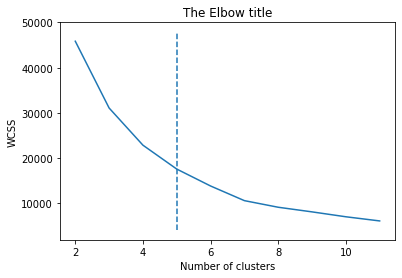

In [24]:
wcss=[]
prev=0

for i in range(2,12):
    kmeans = KMeans(i)
    kmeans.fit(xatt2)
    wcss_iter = kmeans.inertia_
    if prev==0:
        prev=wcss_iter
    else:
        #print(i-1,i,prev-wcss_iter)
        prev=wcss_iter
    wcss.append(wcss_iter)
    


number_clusters = range(2,12)

from kneed import KneeLocator

kn = KneeLocator(number_clusters, wcss, curve='convex', direction='decreasing')
print(kn.knee)


plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')


In [25]:
numk=4

# kmeas 600 all features


In [26]:
kmean = KMeans(n_clusters = numk, init = "k-means++")
kmean.fit(dfsm)

from sklearn.metrics.pairwise import euclidean_distances

labelkm = kmean.fit_predict(dfsm)
scoresm = metrics.silhouette_score(dfsm, kmean.labels_, metric='euclidean')

d = euclidean_distances(dfsm)
diameter_method='farthest'
cdist_method='nearest'
dunkm = dunn(labelkm, d, diameter_method, cdist_method)
dunkm=dunkm*5
dasm=davies_bouldin_score(dfsm, labelkm)


print(scoresm,dunkm,dasm)

"""
fig, ax = plt.subplots() 
plt.scatter(xatt.iloc[:,0], xatt.iloc[:,1], c=kmean.labels_) 
plt.scatter(kmean.cluster_centers_[:,0], kmean.cluster_centers_[:,1],marker='x', color='red')

"""


0.35139493972961394 0.2395481592112206 1.0582437767340935


"\nfig, ax = plt.subplots() \nplt.scatter(xatt.iloc[:,0], xatt.iloc[:,1], c=kmean.labels_) \nplt.scatter(kmean.cluster_centers_[:,0], kmean.cluster_centers_[:,1],marker='x', color='red')\n\n"

In [27]:
cluster_report(dfsm, labelkm, min_samples_leaf=50, pruning_level=0.01)

Index(['GU', 'REFMNG', 'RELMNG', 'EL'], dtype='object')


,class_name,instance_count,rule_list
2,0,154,[0.8872180451127819] RELMNG > 11.5 and EL <= 17.5 and RELMNG <= 22.5[0.5471698113207547] RELMNG > 11.5 and EL <= 17.5 and RELMNG > 22.5
1,1,169,[0.9926470588235294] RELMNG <= 11.5 and REFMNG <= 8.5 and EL <= 2.5[0.5098039215686274] RELMNG <= 11.5 and REFMNG <= 8.5 and EL > 2.5
3,2,135,[0.9396551724137931] RELMNG > 11.5 and EL > 17.5
0,3,207,[0.9659090909090909] RELMNG <= 11.5 and REFMNG > 8.5


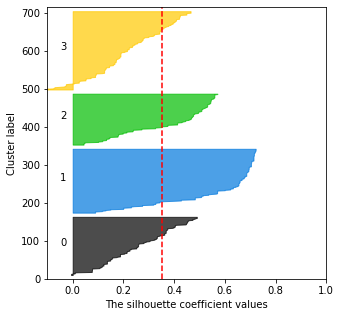

In [28]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

fig, ax1 = plt.subplots()

fig.set_size_inches(5, 5)

ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(xatt2) + (numk + 1) * 10])

sample_silhouette_values = silhouette_samples(dfsm, labelkm)

y_lower = 10
for i in range(numk):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[labelkm == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / numk)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                                  0, ith_cluster_silhouette_values,
                                  facecolor=color, edgecolor=color, alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
ax1.axvline(x=scoresm, color="red", linestyle="--")

In [29]:
# 3 dimension

dfcopy=dfsm.copy(deep=False)
lc=list(dfsm.columns)
lc2=lc.copy()
lenlist=len(lc)
#silhlist=[]
maxsilh=0
maxdun=0
minda=2


for n1 in lc:
    #print('Correlation for '+n1)
    #print(lc.index(n1))
    dfcopy=dfsm.copy(deep=False)
    xatt=dfcopy.drop(columns=[n1],axis=1)
    #print(xatt)
    kmeans1 = KMeans(numk)
    kmeans1.fit(xatt)
    labelkm = kmeans1.fit_predict(xatt)
    scoresm = metrics.silhouette_score(xatt, kmeans1.labels_, metric='euclidean')
    
    d = euclidean_distances(xatt)
    dunkm = dunn(labelkm, d, diameter_method, cdist_method)
    dunkm=dunkm*5
    dasm=davies_bouldin_score(xatt, labelkm)

    #silhlist.append(silhitem)
    if scoresm> maxsilh:
        maxsilh=scoresm
    if dunkm > maxdun:
        maxdun=dunkm
    if dasm < minda:
        minda= dasm

print(maxsilh,maxdun, minda)

0.45556580399566193 0.28747978728803447 0.8819021772749912


# kmeas 300 x=2

Index(['GU', 'REFMNG'], dtype='object')


,class_name,instance_count,rule_list
2,0,75,[0.9733333333333334] REFMNG <= 13.5 and REFMNG <= 5.5
0,1,103,[0.6078431372549019] REFMNG > 13.5 and GU <= 11.5[1.0] REFMNG > 13.5 and GU > 11.5
3,2,33,NaN
1,3,89,[0.8269230769230769] REFMNG <= 13.5 and REFMNG > 5.5


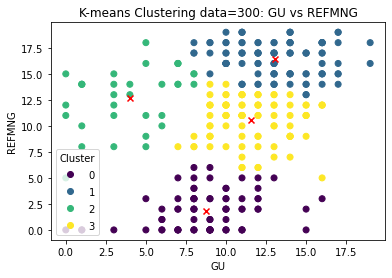

Index(['GU', 'RELMNG'], dtype='object')


,class_name,instance_count,rule_list
0,0,147,[0.9932432432432432] RELMNG <= 7.5
3,1,29,NaN
1,2,67,[0.6875] RELMNG > 7.5 and RELMNG > 17.5
2,3,57,[0.9821428571428571] RELMNG > 7.5 and RELMNG <= 17.5


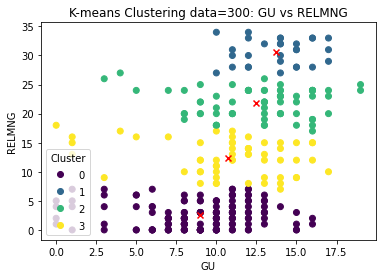

Index(['GU', 'EL'], dtype='object')


,class_name,instance_count,rule_list
0,0,115,[0.9541284403669725] EL <= 3.5
2,1,59,[0.56] EL > 3.5 and EL > 11.5
3,2,43,NaN
1,3,83,[0.8461538461538461] EL > 3.5 and EL <= 11.5


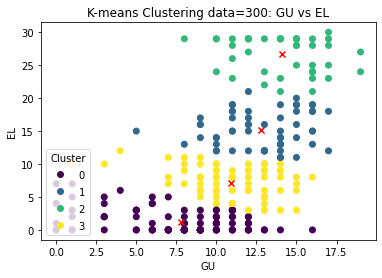

Index(['REFMNG', 'RELMNG'], dtype='object')


,class_name,instance_count,rule_list
2,0,67,[1.0] REFMNG > 6.5 and RELMNG > 10.5 and RELMNG <= 20.5
0,1,83,[1.0] REFMNG <= 6.5
3,2,67,[0.9571428571428572] REFMNG > 6.5 and RELMNG > 10.5 and RELMNG > 20.5
1,3,83,[0.9764705882352941] REFMNG > 6.5 and RELMNG <= 10.5


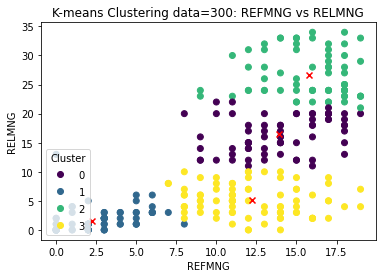

Index(['REFMNG', 'EL'], dtype='object')


,class_name,instance_count,rule_list
2,0,66,[0.9206349206349206] REFMNG > 6.5 and EL > 9.5 and EL <= 18.5
1,1,81,[0.9629629629629629] REFMNG <= 6.5
3,2,44,[0.84] REFMNG > 6.5 and EL > 9.5 and EL > 18.5
0,3,109,[0.9716981132075472] REFMNG > 6.5 and EL <= 9.5


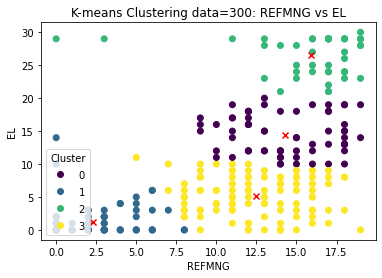

Index(['RELMNG', 'EL'], dtype='object')


,class_name,instance_count,rule_list
0,0,127,[1.0] RELMNG <= 7.5 and EL <= 3.5[0.54] RELMNG <= 7.5 and EL > 3.5
3,1,51,[0.9259259259259259] RELMNG > 7.5 and EL > 17.5
2,2,58,[0.5918367346938775] RELMNG > 7.5 and EL <= 17.5
1,3,64,NaN


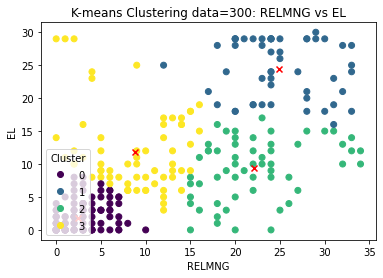

In [30]:
lc=list(df.columns)
lc2=lc.copy()
#silhlist=[]

for n1 in lc:
    #print('Correlation for '+n1)
    #print(lc.index(n1))
    lc2.remove(n1)
    for n2 in lc2:
        aa1=lc.index(n1)
        aa2=lc.index(n2)
        xatt2=df.iloc[:,lambda df: [aa1, aa2]]
        
        kmeans1 = KMeans(numk)
        kmeans1.fit(xatt2)
        identified_clusters = kmeans1.fit_predict(xatt2)
        
        scoresm = metrics.silhouette_score(xatt2, kmeans1.labels_, metric='euclidean')
        #silhitem=[lc[lc.index(n1)],lc2[lc2.index(n2)],scoresm]
        #silhlist.append(silhitem)
        
        cluster_report(xatt2, identified_clusters, min_samples_leaf=50, pruning_level=0.01)
        
        fig, ax = plt.subplots()
        scatter=plt.scatter(df.iloc[:,aa1], df.iloc[:,aa2], c=kmeans1.labels_) 
        plt.scatter(kmeans1.cluster_centers_[:,0], kmeans1.cluster_centers_[:,1],marker='x', color='red')
        plt.title('K-means Clustering data=300: '+lc[lc.index(n1)] + ' vs '+ lc2[lc2.index(n2)])
        #+ ' Silhouetter Score: %.3f' % scoresm
        plt.xlabel(lc[lc.index(n1)])
        plt.ylabel(lc2[lc2.index(n2)])
        plt.legend(*scatter.legend_elements(),loc="lower left", title="Cluster")
        plt.show()

# k-means sampling

2 3 17863.11373504655
3 4 9900.118939837208
4 5 7706.792618028809
5 6 4888.280009791779
6 7 3229.6627957193923
7 8 2299.4471217478167
8 9 1430.2958979592586
9 10 1444.1854762951189
10 11 1578.0153148009558
5


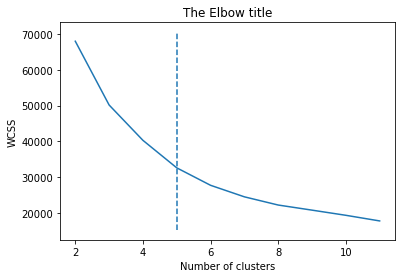

In [31]:
wcss=[]
prev=0
a1=2
a2=3
xattsm1=dfsm.iloc[:,lambda df: [a1,a2]]

for i in range(2,12):
    kmeans = KMeans(i)
    kmeans.fit(dfsm)
    wcss_iter = kmeans.inertia_
    if prev==0:
        prev=wcss_iter
    else:
        print(i-1,i,prev-wcss_iter)
        prev=wcss_iter
    wcss.append(wcss_iter)

number_clusters = range(2,12)
kn = KneeLocator(number_clusters, wcss, curve='convex', direction='decreasing')
print(kn.knee)

plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

Index(['GU', 'REFMNG'], dtype='object')


,class_name,instance_count,rule_list
0,0,240,[0.9782608695652174] REFMNG > 13.5 and GU > 8.5
1,1,196,[0.9811320754716981] REFMNG <= 13.5 and REFMNG > 5.5 and GU > 9.5
3,2,78,[0.5] REFMNG <= 13.5 and REFMNG > 5.5 and GU <= 9.5[0.76] REFMNG > 13.5 and GU <= 8.5
2,3,151,[0.9864864864864865] REFMNG <= 13.5 and REFMNG <= 5.5


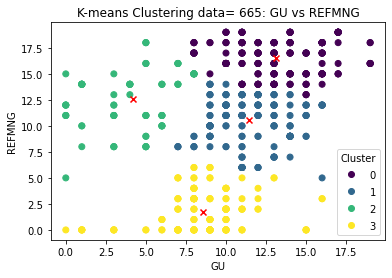

Index(['GU', 'RELMNG'], dtype='object')


,class_name,instance_count,rule_list
1,0,142,[0.922077922077922] RELMNG > 6.5 and RELMNG > 16.5 and RELMNG <= 27.5
0,1,311,[1.0] RELMNG <= 6.5
2,2,134,[0.9571428571428572] RELMNG > 6.5 and RELMNG <= 16.5
3,3,78,[1.0] RELMNG > 6.5 and RELMNG > 16.5 and RELMNG > 27.5


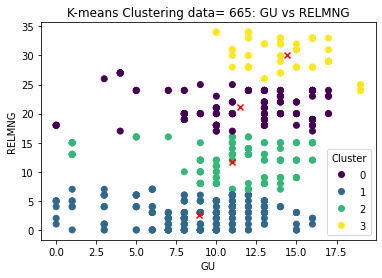

Index(['GU', 'EL'], dtype='object')


,class_name,instance_count,rule_list
0,0,256,[0.9822222222222222] EL <= 3.5
2,1,126,[0.984375] EL > 3.5 and EL > 11.5 and EL <= 21.5
3,2,94,[1.0] EL > 3.5 and EL > 11.5 and EL > 21.5
1,3,189,[0.5178571428571429] EL > 3.5 and EL <= 11.5 and EL <= 5.5[0.950920245398773] EL > 3.5 and EL <= 11.5 and EL > 5.5


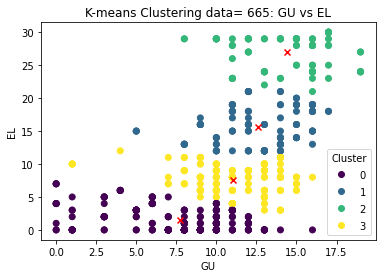

Index(['REFMNG', 'RELMNG'], dtype='object')


,class_name,instance_count,rule_list
1,0,164,[1.0] REFMNG > 6.5 and RELMNG > 12.5 and RELMNG <= 22.5
0,1,215,[0.9295154185022027] REFMNG > 6.5 and RELMNG <= 12.5
3,2,123,[0.9919354838709677] REFMNG > 6.5 and RELMNG > 12.5 and RELMNG > 22.5
2,3,163,[0.975609756097561] REFMNG <= 6.5


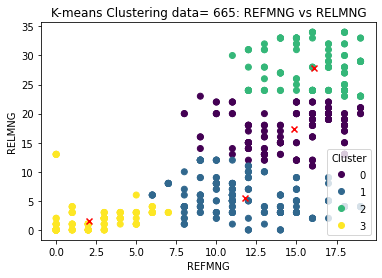

Index(['REFMNG', 'EL'], dtype='object')


,class_name,instance_count,rule_list
0,0,263,[0.9770114942528736] REFMNG > 6.5 and EL <= 9.5
3,1,101,[1.0] REFMNG > 6.5 and EL > 9.5 and EL > 20.5
1,2,162,[0.9512195121951219] REFMNG <= 6.5
2,3,139,[0.9586206896551724] REFMNG > 6.5 and EL > 9.5 and EL <= 20.5


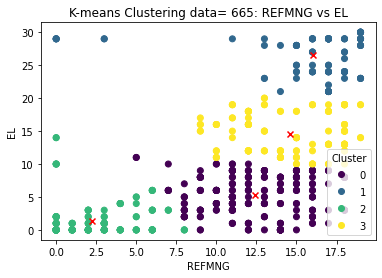

Index(['RELMNG', 'EL'], dtype='object')


,class_name,instance_count,rule_list
1,0,146,[1.0] RELMNG > 10.5 and EL <= 13.5 and EL <= 9.5[0.6727272727272727] RELMNG > 10.5 and EL <= 13.5 and EL > 9.5
2,1,139,[1.0] RELMNG > 10.5 and EL > 13.5 and RELMNG > 20.5
0,2,323,[0.9900332225913622] RELMNG <= 10.5 and EL <= 8.5
3,3,57,[0.5614035087719298] RELMNG <= 10.5 and EL > 8.5[0.43859649122807015] RELMNG > 10.5 and EL > 13.5 and RELMNG <= 20.5


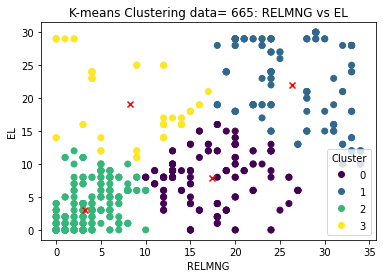

In [32]:
lcsm=list(dfsm.columns)
lc2sm=lcsm.copy()

silhsmlist=[]

lendfsm=str(len(dfsm))

for n1 in lcsm:
    #print('Correlation for '+n1)
    #print(lc.index(n1))
    lc2sm.remove(n1)
    for n2 in lc2sm:
        aa1=lcsm.index(n1)
        aa2=lcsm.index(n2)
        xattsm=dfsm.iloc[:,lambda datafsm: [aa1, aa2]]
        kmeanssm = KMeans(numk)
        kmeanssm.fit(xattsm)
        identified_clusters = kmeanssm.fit_predict(xattsm)
        
        cluster_report(xattsm, identified_clusters, min_samples_leaf=50, pruning_level=0.01)
        
        fig, ax = plt.subplots()
        scatter=plt.scatter(dfsm.iloc[:,aa1], dfsm.iloc[:,aa2], c=kmeanssm.labels_) 
        plt.scatter(kmeanssm.cluster_centers_[:,0], kmeanssm.cluster_centers_[:,1],marker='x', color='red')
        plt.title('K-means Clustering data= '+ lendfsm+ ': ' +lcsm[lcsm.index(n1)] + ' vs '+ lc2sm[lc2sm.index(n2)])
        plt.xlabel(lcsm[lcsm.index(n1)])
        plt.ylabel(lc2sm[lc2sm.index(n2)])
        plt.legend(*scatter.legend_elements(),loc="lower right", title="Cluster")
        plt.show()

# Silhouette and Dunn for K-means

In [33]:
lc=list(df.columns)
lc2=lc.copy()
silhlist2=[]

for n1 in lc:
    #print('Correlation for '+n1)
    #print(lc.index(n1))
    lc2.remove(n1)
    for n2 in lc2:
        aa1=lc.index(n1)
        aa2=lc.index(n2)
        name2=str(n1 +' and '+n2)
        xatt2=df.iloc[:,lambda df: [aa1, aa2]]
        xattsm=dfsm.iloc[:,lambda dfsm: [aa1, aa2]]
        
        kmeanssm = KMeans(numk)
        kmeanssm.fit(xattsm)
        kmeans1 = KMeans(numk)
        kmeans1.fit(xatt2)
        
        scoresm = metrics.silhouette_score(xatt2, kmeans1.labels_, metric='euclidean')
        scoresm=round(scoresm,4)
        scoresmsm = metrics.silhouette_score(xattsm, kmeanssm.labels_, metric='euclidean')
        scoresmsm=round(scoresmsm,4)
        silhitem=[name2,scoresm,scoresmsm]
        silhlist2.append(silhitem)

silhdf2 = pd.DataFrame(silhlist2, columns =['Attributes','Silhouetter Score','Sampling Silhouetter Score'])
silhdf2.head(10)

,Attributes,Silhouetter Score,Sampling Silhouetter Score
0,GU and REFMNG,0.4410,0.4475
1,GU and RELMNG,0.4707,0.4635
2,GU and EL,0.4210,0.4539
3,REFMNG and RELMNG,0.5016,0.5042
4,REFMNG and EL,0.4875,0.4793
5,RELMNG and EL,0.4692,0.5213


# Dunn Index

In [34]:
from sklearn.metrics.pairwise import euclidean_distances

lc=list(df.columns)
lc2=lc.copy()
dunnlist=[]
diameter_method='farthest'
cdist_method='nearest'


for n1 in lc:
    #print('Correlation for '+n1)
    #print(lc.index(n1))
    lc2.remove(n1)
    for n2 in lc2:
        aa1=lc.index(n1)
        aa2=lc.index(n2)
        name2=str(n1 +' and '+n2)
        xatt2=df.iloc[:,lambda df: [aa1, aa2]]
        kmeans1 = KMeans(numk)
        k = kmeans1.fit_predict(xatt2)
        d = euclidean_distances(xatt2)
        dunk = 10*dunn(k, d, diameter_method, cdist_method)
        dunk=round(dunk,4)
        
        xattsm=dfsm.iloc[:,lambda dfsm: [aa1, aa2]]
        kmeanssm = KMeans(numk)
        ksm = kmeanssm.fit_predict(xattsm)
        dsm = euclidean_distances(xattsm)
        dunksm = 10*dunn(ksm, dsm, diameter_method, cdist_method)
        dunksm=round(dunksm,4)
        
        dunnitem=[name2,dunk,dunksm]
        dunnlist.append(dunnitem)

dunndf = pd.DataFrame(dunnlist, columns =['Attributes','DunnIndex','Sampling DunnIndex'])
dunndf.head(10)

,Attributes,DunnIndex,Sampling DunnIndex
0,GU and REFMNG,0.6143,0.6143
1,GU and RELMNG,0.5322,0.5617
2,GU and EL,0.5726,0.5726
3,REFMNG and RELMNG,0.6934,0.6934
4,REFMNG and EL,0.5019,0.5019
5,RELMNG and EL,0.4311,0.4152


# Davies-Bouldin Index

In [35]:
from sklearn.metrics import davies_bouldin_score

lc=list(df.columns)
lc2=lc.copy()
davieslist=[]
diameter_method='farthest'
cdist_method='nearest'


for n1 in lc:
    #print('Correlation for '+n1)
    #print(lc.index(n1))
    lc2.remove(n1)
    for n2 in lc2:
        aa1=lc.index(n1)
        aa2=lc.index(n2)
        name2=str(n1 +' and '+n2)
        xatt2=df.iloc[:,lambda df: [aa1, aa2]]
        kmeans1 = KMeans(numk)
        kmeans1.fit(xatt2)
        labels = kmeans1.labels_
        dab=davies_bouldin_score(xatt2, labels)
        
        
        xattsm=dfsm.iloc[:,lambda dfsm: [aa1, aa2]]
        kmeanssm = KMeans(numk)
        kmeanssm.fit(xattsm)
        labelsm = kmeanssm.labels_
        dabsm=davies_bouldin_score(xattsm, labelsm)
        
        
        daviesitem=[name2,dab,dabsm]
        davieslist.append(daviesitem)

daviesdf = pd.DataFrame(davieslist, columns =['Attributes','Davies','Sampling Davies'])
daviesdf.head(10)

,Attributes,Davies,Sampling Davies
0,GU and REFMNG,0.794247,0.784450
1,GU and RELMNG,0.785641,0.801793
2,GU and EL,0.816480,0.781758
3,REFMNG and RELMNG,0.691628,0.677378
4,REFMNG and EL,0.716913,0.725633
5,RELMNG and EL,0.865231,0.815596


# -------------------------------------------Hierarchical----------------------------------------------

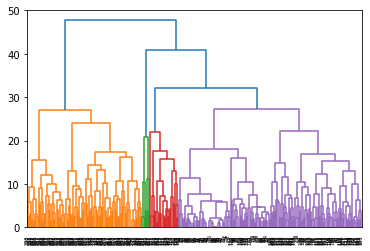

In [36]:
linked = linkage(df, 'complete') 
dendrogram(linked, orientation='top', distance_sort='ascending', show_leaf_counts=False,color_threshold=27.5) 
plt.show()

In [42]:
modelac = AgglomerativeClustering(n_clusters=numk, linkage='single')
modelac.fit(dfsm)

aclabel = modelac.fit_predict(dfsm)

scoresm = metrics.silhouette_score(dfsm, modelac.labels_, metric='euclidean')

d = euclidean_distances(dfsm)
diameter_method='farthest'
cdist_method='nearest'
dunk = 5*dunn(aclabel, d, diameter_method, cdist_method)
dasm=davies_bouldin_score(dfsm, aclabel)

print(scoresm,dunk,dasm)


0.036560885796620174 0.8516306272526402 0.7762649701574127


In [44]:
cluster_report(dfsm, aclabel, min_samples_leaf=50, pruning_level=0.01)

Index(['GU', 'REFMNG', 'RELMNG', 'EL'], dtype='object')


,class_name,instance_count,rule_list
0,0,654,[0.9834586466165414] ALL
2,1,4,NaN
1,2,6,NaN
3,3,1,NaN


In [43]:
# 3 dimension

dfcopy=dfsm.copy(deep=False)
lc=list(dfsm.columns)
lc2=lc.copy()
lenlist=len(lc)
#silhlist=[]
maxsilh=0
maxdun=0
minda=2


for n1 in lc:
    #print('Correlation for '+n1)
    #print(lc.index(n1))
    dfcopy=dfsm.copy(deep=False)
    xatt=dfcopy.drop(columns=[n1],axis=1)
    #print(xatt)
    lac1 = AgglomerativeClustering(n_clusters=numk, linkage='complete')
    lac1.fit(xatt)
    aclabel = modelac.fit_predict(dfsm)
    scoresm = metrics.silhouette_score(dfsm, lac1.labels_, metric='euclidean')
    
    d = euclidean_distances(xatt)
    dunkm = dunn(aclabel, d, diameter_method, cdist_method)
    dunkm=dunkm*5
    dasm=davies_bouldin_score(xatt, aclabel)

    #silhlist.append(silhitem)
    if scoresm> maxsilh:
        maxsilh=scoresm
    if dunkm > maxdun:
        maxdun=dunkm
    if dasm < minda:
        minda= dasm

print(maxsilh,maxdun, minda)

0.3950334751473653 0.8792458493268623 0.5883067062035136


# 300

Index(['GU', 'REFMNG'], dtype='object')


,class_name,instance_count,rule_list
0,0,119,[0.7093023255813954] REFMNG <= 11.5 and GU <= 10.5[1.0] REFMNG <= 11.5 and GU > 10.5
1,1,86,[0.8764044943820225] REFMNG > 11.5 and GU <= 12.5
2,2,78,[1.0] REFMNG > 11.5 and GU > 12.5
3,3,17,NaN


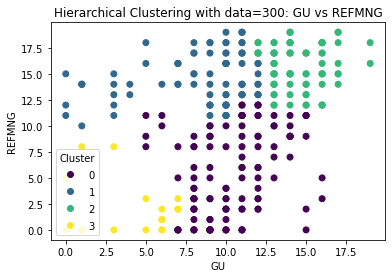

Index(['GU', 'RELMNG'], dtype='object')


,class_name,instance_count,rule_list
1,0,72,[0.5] RELMNG > 5.5 and RELMNG > 15.5 and RELMNG <= 23.5[0.8679245283018868] RELMNG > 5.5 and RELMNG > 15.5 and RELMNG > 23.5
0,1,134,[0.9689922480620154] RELMNG <= 5.5
3,2,39,NaN
2,3,55,[0.7727272727272727] RELMNG > 5.5 and RELMNG <= 15.5


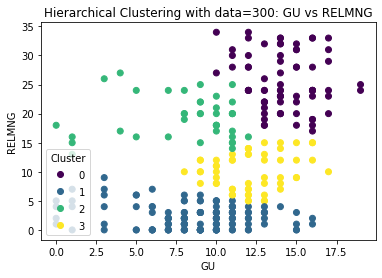

Index(['GU', 'EL'], dtype='object')


,class_name,instance_count,rule_list
0,0,107,[0.9029126213592233] GU <= 9.5
2,1,57,[0.5684210526315789] GU > 9.5 and EL > 10.5
3,2,36,NaN
1,3,100,[0.9215686274509803] GU > 9.5 and EL <= 10.5


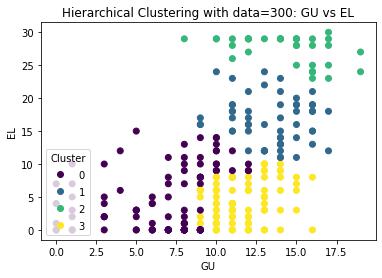

Index(['REFMNG', 'RELMNG'], dtype='object')


,class_name,instance_count,rule_list
1,0,77,[1.0] REFMNG > 8.5 and RELMNG > 10.5 and RELMNG <= 22.5
0,1,96,[0.9578947368421052] REFMNG <= 8.5
3,2,57,[0.95] REFMNG > 8.5 and RELMNG > 10.5 and RELMNG > 22.5
2,3,70,[0.9305555555555556] REFMNG > 8.5 and RELMNG <= 10.5


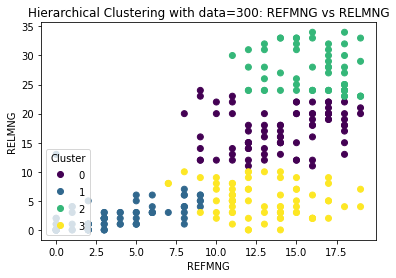

Index(['REFMNG', 'EL'], dtype='object')


,class_name,instance_count,rule_list
0,0,168,[0.9938271604938271] REFMNG > 6.5 and EL <= 17.5
2,1,53,[0.9298245614035088] REFMNG > 6.5 and EL > 17.5
1,2,77,[0.9382716049382716] REFMNG <= 6.5
3,3,2,NaN


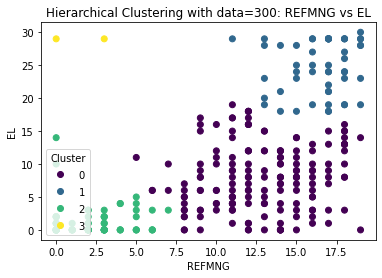

Index(['RELMNG', 'EL'], dtype='object')


,class_name,instance_count,rule_list
2,0,52,[0.7884615384615384] RELMNG > 13.5 and EL > 17.5
1,1,66,[0.746268656716418] RELMNG > 13.5 and EL <= 17.5
3,2,7,NaN
0,3,175,[0.9337016574585635] RELMNG <= 13.5


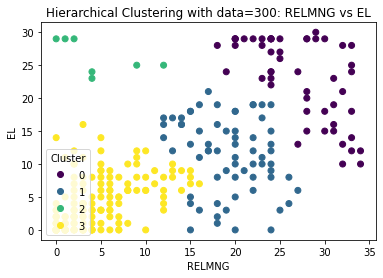

In [45]:
#data=300

lc=list(df.columns)
lc2=lc.copy()

ahsilhlist=[]


for n1 in lc:
    #print('Correlation for '+n1)
    #print(lc.index(n1))
    lc2.remove(n1)
    for n2 in lc2:
        aa1=lc.index(n1)
        aa2=lc.index(n2)
        xatt2=df.iloc[:,lambda df: [aa1, aa2]]
        modelac2 = AgglomerativeClustering(n_clusters=numk, linkage='complete')
        modelac2.fit(xatt2)
        yac=modelac2.fit_predict(xatt2)

        cluster_report(xatt2, yac, min_samples_leaf=50, pruning_level=0.01)
        
        fig, ax = plt.subplots()
        scatter=plt.scatter(df.iloc[:,aa1], df.iloc[:,aa2], c=yac) 
        plt.title('Hierarchical Clustering with data=300: '+n1 + ' vs '+ n2)
        plt.xlabel(lc[lc.index(n1)])
        plt.ylabel(lc2[lc2.index(n2)])
        plt.legend(*scatter.legend_elements(),loc="lower left", title="Cluster")
        plt.show()

# 600

Index(['GU', 'REFMNG'], dtype='object')


,class_name,instance_count,rule_list
0,0,377,[0.9766839378238342] REFMNG > 9.5 and GU > 7.5
2,1,106,[0.8467741935483871] REFMNG <= 9.5 and REFMNG <= 3.5
3,2,69,[1.0] REFMNG > 9.5 and GU <= 7.5
1,3,113,[0.8854166666666666] REFMNG <= 9.5 and REFMNG > 3.5


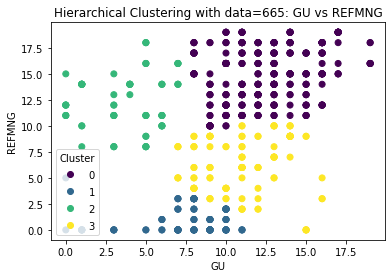

Index(['GU', 'RELMNG'], dtype='object')


,class_name,instance_count,rule_list
2,0,172,[0.9867549668874173] RELMNG > 15.5 and GU > 11.5
0,1,244,[0.66] RELMNG <= 15.5 and GU > 9.5 and RELMNG <= 2.5[1.0] RELMNG <= 15.5 and GU > 9.5 and RELMNG > 2.5
3,2,66,[0.7012987012987013] RELMNG > 15.5 and GU <= 11.5
1,3,183,[1.0] RELMNG <= 15.5 and GU <= 9.5 and RELMNG <= 4.5[0.55] RELMNG <= 15.5 and GU <= 9.5 and RELMNG > 4.5


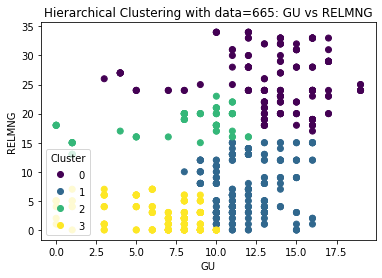

Index(['GU', 'EL'], dtype='object')


,class_name,instance_count,rule_list
2,0,174,[0.9664804469273743] EL > 13.5
1,1,182,[0.9797297297297297] EL <= 13.5 and EL <= 5.5 and GU > 8.5
0,2,186,[0.9624060150375939] EL <= 13.5 and EL > 5.5 and GU <= 12.5[0.6805555555555556] EL <= 13.5 and EL > 5.5 and GU > 12.5
3,3,123,[0.8872180451127819] EL <= 13.5 and EL <= 5.5 and GU <= 8.5


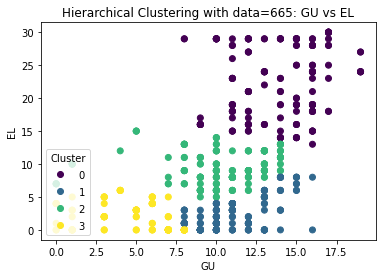

Index(['REFMNG', 'RELMNG'], dtype='object')


,class_name,instance_count,rule_list
1,0,199,[0.9554455445544554] RELMNG > 8.5 and RELMNG <= 22.5
0,1,274,[0.9814814814814815] RELMNG <= 8.5 and REFMNG <= 12.5
2,2,123,[0.9919354838709677] RELMNG > 8.5 and RELMNG > 22.5
3,3,69,[0.927536231884058] RELMNG <= 8.5 and REFMNG > 12.5


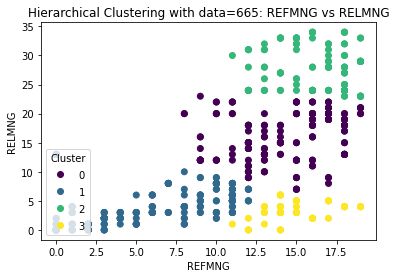

Index(['REFMNG', 'EL'], dtype='object')


,class_name,instance_count,rule_list
0,0,319,[0.4603174603174603] REFMNG <= 10.5 and EL > 5.5[0.9756944444444444] REFMNG > 10.5 and EL <= 17.5
2,1,120,[0.9302325581395349] REFMNG > 10.5 and EL > 17.5
1,2,220,[1.0] REFMNG <= 10.5 and EL <= 5.5
3,3,6,NaN


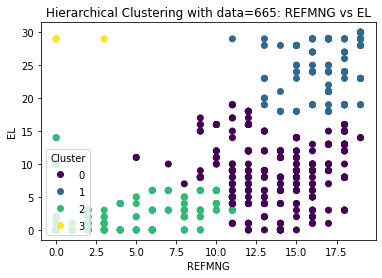

Index(['RELMNG', 'EL'], dtype='object')


,class_name,instance_count,rule_list
2,0,131,[0.6491228070175439] RELMNG > 10.5 and EL <= 18.5 and RELMNG > 22.5[0.9215686274509803] RELMNG > 10.5 and EL > 18.5
1,1,174,[1.0] RELMNG > 10.5 and EL <= 18.5 and RELMNG <= 22.5
3,2,21,NaN
0,3,339,[1.0] RELMNG <= 10.5 and EL <= 8.5[0.6666666666666666] RELMNG <= 10.5 and EL > 8.5


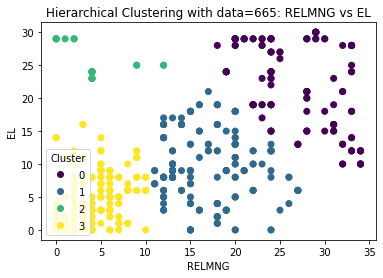

In [47]:
#--------------------------------------data=600---------------------------------------------

lcsm=list(dfsm.columns)
lc2sm=lcsm.copy()

ahsilhsmlist=[]

for n1 in lcsm:
    #print('Correlation for '+n1)
    #print(lc.index(n1))
    lc2sm.remove(n1)
    for n2 in lc2sm:
        aa1=lcsm.index(n1)
        aa2=lcsm.index(n2)
        xattsm=dfsm.iloc[:,lambda dfsm: [aa1, aa2]]
        modelacsm = AgglomerativeClustering(n_clusters=numk, linkage='complete')
        modelacsm.fit(xattsm)
        identified_clusters = modelacsm.fit_predict(xattsm)
        
        cluster_report(xattsm, identified_clusters, min_samples_leaf=50, pruning_level=0.01)
        
        fig, ax = plt.subplots()
        scatter=ax.scatter(dfsm.iloc[:,aa1], dfsm.iloc[:,aa2], c=modelacsm.labels_)
        plt.title('Hierarchical Clustering with data='+ lendfsm+ ': ' +n1 + ' vs '+ n2)
        plt.xlabel(lcsm[lcsm.index(n1)])
        plt.ylabel(lc2sm[lc2sm.index(n2)])
        plt.legend(*scatter.legend_elements(),loc="lower left", title="Cluster")
        plt.show()



# Silhouette and Dunn AC

In [48]:
#Silhouette

lc=list(df.columns)
lc2=lc.copy()
ahsilhlist=[]

for n1 in lc:
    #print('Correlation for '+n1)
    #print(lc.index(n1))
    lc2.remove(n1)
    for n2 in lc2:
        aa1=lc.index(n1)
        aa2=lc.index(n2)
        name2=str(n1 +' and '+n2)
        xatt2=df.iloc[:,lambda df: [aa1, aa2]]
        modelac2 = AgglomerativeClustering(n_clusters=numk, linkage='single')
        modelac2.fit(xatt2)
        ahscoresm = metrics.silhouette_score(xatt2, modelac2.labels_, metric='euclidean')
        ahscoresm=round(ahscoresm,4)
        
        xattsm=dfsm.iloc[:,lambda dfsm: [aa1, aa2]]
        modelacsm = AgglomerativeClustering(n_clusters=numk, linkage='single')
        modelacsm.fit(xattsm)
        ahscoresmsm = metrics.silhouette_score(xattsm, modelacsm.labels_, metric='euclidean')
        ahscoresmsm=round(ahscoresmsm,4)
        
        ahsilhitem=[name2,ahscoresm,ahscoresmsm]
        ahsilhlist.append(ahsilhitem)

ahsilhdf2 = pd.DataFrame(ahsilhlist, columns =['Attributes','Silhouetter Score','Sampling Silhouetter Score'])
ahsilhdf2.sort_values(by='Sampling Silhouetter Score',ascending=False).head(10)

,Attributes,Silhouetter Score,Sampling Silhouetter Score
5,RELMNG and EL,0.1519,0.1698
0,GU and REFMNG,0.0831,0.1036
4,REFMNG and EL,0.0193,0.0600
1,GU and RELMNG,0.0219,0.0333
2,GU and EL,-0.0689,-0.0544
3,REFMNG and RELMNG,-0.1255,-0.3428


The average silhouette_score is : 0.4102263273639724


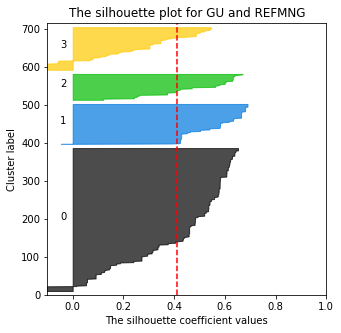

The average silhouette_score is : 0.3031255457794542


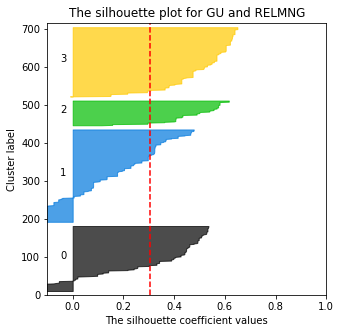

The average silhouette_score is : 0.36683138783321717


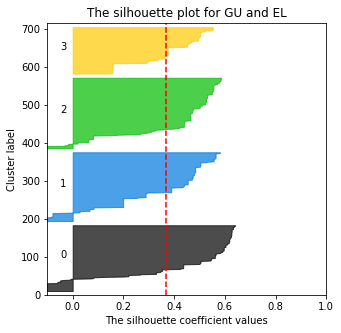

The average silhouette_score is : 0.3919466666864993


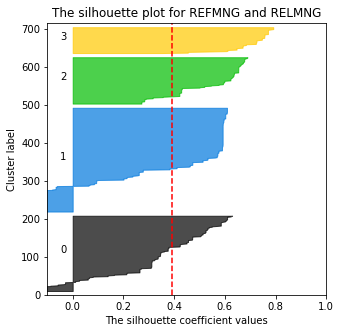

The average silhouette_score is : 0.46790114563912905


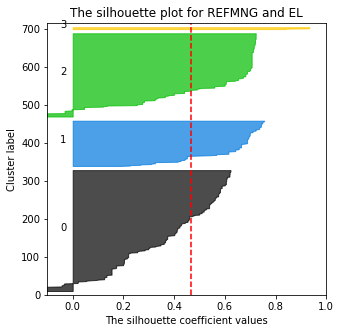

The average silhouette_score is : 0.5184108692569233


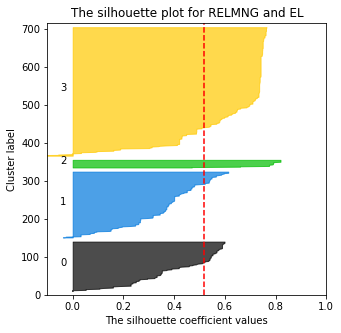

In [50]:
lcsm=list(dfsm.columns)
lc2sm=lcsm.copy()

ahsilhsmlist=[]

for n1 in lcsm:
    #print('Correlation for '+n1)
    #print(lc.index(n1))
    lc2sm.remove(n1)
    for n2 in lc2sm:
        aa1=lcsm.index(n1)
        aa2=lcsm.index(n2)
        xattsm=dfsm.iloc[:,lambda dfsm: [aa1, aa2]]
        modelacsm = AgglomerativeClustering(n_clusters=numk, linkage='complete')
        modelacsm.fit(xattsm)
        identified_clusters = modelacsm.fit_predict(xattsm)
        
        cluster_labels=modelacsm.labels_
        scoresm = metrics.silhouette_score(xattsm, cluster_labels, metric='euclidean')
        
        if scoresm > 0.1:
            print("The average silhouette_score is :", scoresm)
            fig, ax1 = plt.subplots()

            fig.set_size_inches(5, 5)

            ax1.set_xlim([-0.1, 1])
            ax1.set_ylim([0, len(xattsm) + (numk + 1) * 10])

            sample_silhouette_values = silhouette_samples(xattsm, cluster_labels)

            y_lower = 10
            for i in range(numk):
                ith_cluster_silhouette_values = \
                        sample_silhouette_values[cluster_labels == i]

                ith_cluster_silhouette_values.sort()

                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i

                color = cm.nipy_spectral(float(i) / numk)
                ax1.fill_betweenx(np.arange(y_lower, y_upper),
                                  0, ith_cluster_silhouette_values,
                                  facecolor=color, edgecolor=color, alpha=0.7)
                ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                y_lower = y_upper + 10  # 10 for the 0 samples
  
            ax1.set_title("The silhouette plot for "+ lcsm[lcsm.index(n1)] + ' and '+ lc2sm[lc2sm.index(n2)])
            ax1.set_xlabel("The silhouette coefficient values")
            ax1.set_ylabel("Cluster label")
            ax1.axvline(x=scoresm, color="red", linestyle="--")
            
            
        plt.show()
        
        
        plt.show()

In [52]:
#dunnindex Hierarchical


from sklearn.metrics.pairwise import euclidean_distances

lc=list(df.columns)
lc2=lc.copy()
acdunnlist=[]
diameter_method='farthest'
cdist_method='nearest'

for n1 in lc:
    #print('Correlation for '+n1)
    #print(lc.index(n1))
    lc2.remove(n1)
    for n2 in lc2:
        aa1=lc.index(n1)
        aa2=lc.index(n2)
        name2=str(n1 +' and '+n2)
        xatt2=df.iloc[:,lambda df: [aa1, aa2]]
        modelac2 = AgglomerativeClustering(n_clusters=numk, linkage='complete')
        k = modelac2.fit_predict(xatt2)
        d = euclidean_distances(xatt2)
        acdunk = 5*dunn(k, d, diameter_method, cdist_method)
        acdunk=round(acdunk,4)
        
        
        xatt2sm=dfsm.iloc[:,lambda df: [aa1, aa2]]
        modelac2sm = AgglomerativeClustering(n_clusters=numk, linkage='complete')
        ksm = modelac2sm.fit_predict(xatt2sm)
        dsm = euclidean_distances(xatt2sm)
        acsmdunk = 5*dunn(ksm, dsm, diameter_method, cdist_method)
        acsmdunk=round(acsmdunk,4)
        
        acdunnitem=[name2,acdunk,acsmdunk]
        acdunnlist.append(acdunnitem)

acdunndf = pd.DataFrame(acdunnlist, columns =['Attributes','DunnIndex','Sampling DunnIndex'])
acdunndf.sort_values(by='Sampling DunnIndex',ascending=False).head(10)


,Attributes,DunnIndex,Sampling DunnIndex
3,REFMNG and RELMNG,0.3386,0.4138
0,GU and REFMNG,0.3363,0.3904
5,RELMNG and EL,0.2936,0.2936
2,GU and EL,0.2906,0.2795
1,GU and RELMNG,0.2774,0.2774
4,REFMNG and EL,0.2425,0.2575


In [53]:
from sklearn.metrics import davies_bouldin_score

lc=list(df.columns)
lc2=lc.copy()
davieslist=[]
diameter_method='farthest'
cdist_method='nearest'


for n1 in lc:
    #print('Correlation for '+n1)
    #print(lc.index(n1))
    lc2.remove(n1)
    for n2 in lc2:
        aa1=lc.index(n1)
        aa2=lc.index(n2)
        name2=str(n1 +' and '+n2)
        xatt2=df.iloc[:,lambda df: [aa1, aa2]]
        modelac2 = AgglomerativeClustering(n_clusters=numk, linkage='complete')
        modelac2.fit(xatt2)
        labels = modelac2.labels_
        dab=davies_bouldin_score(xatt2, labels)
        dab=round(dab,4)
        
        
        xattsm=dfsm.iloc[:,lambda dfsm: [aa1, aa2]]
        modelacsm = AgglomerativeClustering(n_clusters=numk, linkage='complete')
        modelacsm.fit(xattsm)
        labelsm = modelacsm.labels_
        dabsm=davies_bouldin_score(xattsm, labelsm)
        dabsm=round(dabsm,4)
        
        
        daviesitem=[name2,dab,dabsm]
        davieslist.append(daviesitem)

daviesdf = pd.DataFrame(davieslist, columns =['Attributes','Davies','Sampling Davies'])
daviesdf.head(10)

,Attributes,Davies,Sampling Davies
0,GU and REFMNG,1.0296,0.8071
1,GU and RELMNG,0.9219,1.0073
2,GU and EL,1.1710,0.8591
3,REFMNG and RELMNG,0.7120,0.7074
4,REFMNG and EL,0.5246,0.5992
5,RELMNG and EL,0.7618,0.7186


# Random Forest

In [42]:
a1=1
a2=2
xsm=dfsm.iloc[:,lambda df: [a1,a2]]
print(xsm)

     REFMNG  RELMNG
77       10      22
18        0       0
73        5       3
40        0       0
23        1       4
..      ...     ...
15        4       3
169      14       2
141       0      13
156      10       9
85        0       0

[665 rows x 2 columns]


In [43]:
krf= KMeans(numk)
krf.fit(xsm)
ykm= krf.labels_

acrf = AgglomerativeClustering(n_clusters=numk, linkage='complete')
acrf.fit(xsm)
yac=acrf.labels_

In [44]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split


xkm_train,xkm_test,ykm_train,ykm_test= train_test_split(xsm,ykm,test_size=0.3,random_state=0)
xac_train,xac_test,yac_train,yac_test= train_test_split(xsm,yac,test_size=0.3,random_state=0)


Text(0.5, 24.0, 'Predicted label')

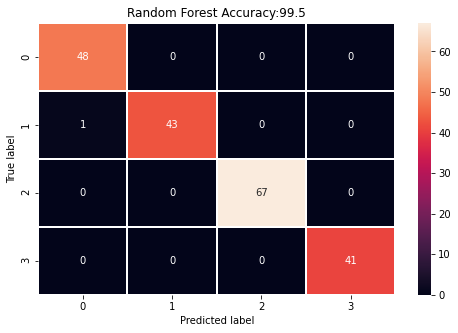

In [45]:
from sklearn.ensemble import RandomForestClassifier

#max_depth=6,,min_samples_leaf=2,n_estimators=100
crfm=RandomForestClassifier(max_depth=17)

#Train the model using the training sets y_pred=clf.predict(X_test)
crfm.fit(xkm_train,ykm_train)

ykm_pred=crfm.predict(xkm_test)

cmrfm=confusion_matrix(ykm_test, ykm_pred)

# Transform to dataframe for easier plotting
cmrfm_df=pd.DataFrame(cmrfm) 

plt.figure(figsize=(8,5))
sns.heatmap(cmrfm_df, annot=True,linewidths=1, fmt = 'd')

plt.title("Random Forest Accuracy:"+str(crfm.score(xkm_test,ykm_test)*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')

Text(0.5, 24.0, 'Predicted label')

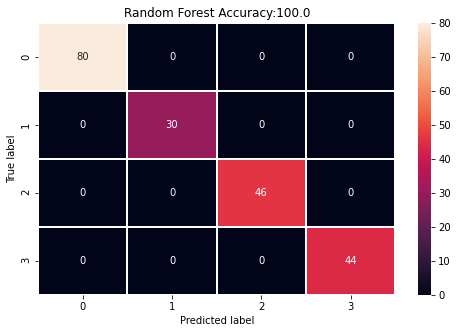

In [46]:
from sklearn.ensemble import RandomForestClassifier

#max_depth=6,,min_samples_leaf=2,n_estimators=100
crfa=RandomForestClassifier(max_depth=17)

#Train the model using the training sets y_pred=clf.predict(X_test)
crfa.fit(xac_train,yac_train)

yac_pred=crfa.predict(xac_test)

cmrfa=confusion_matrix(yac_test, yac_pred)

# Transform to dataframe for easier plotting
cmrfa_df=pd.DataFrame(cmrfa) 

plt.figure(figsize=(8,5))
sns.heatmap(cmrfa_df, annot=True,linewidths=1, fmt = 'd')

plt.title("Random Forest Accuracy:"+str(crfa.score(xac_test,yac_test)*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')